In [1]:
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/UniGe/Machine_Learning2/VariousDatasets/sign_mnist_train/sign_mnist_train.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [27]:
nl = 150

def load_training_data(path):
  df = pd.read_csv(path)

  for i in range(0,25):
    if (i == 9 or i == 25):
      continue
    else:
      temp = df.loc[df['label'] == i]
      #print(temp)

      temp_sub = temp.drop('label', axis=1).to_numpy()


      #x = np.array([temp_sub.iloc[k].to_numpy().reshape((28, 28))
        #for k in range(len(temp_sub))]).astype(float)
      #x = np.expand_dims(x, axis=3)

      if (i == 0):
        XL = temp_sub[range(0,nl),:]
        YL = i*np.ones(nl)
      else:
        XL = np.concatenate((XL,temp_sub[range(0,nl),:]),axis=0)
        YL = np.append(YL,i*np.ones(nl))
  #YL = pd.get_dummies(YL).values

  return XL, YL

X_train, Y_train = load_training_data('/content/drive/MyDrive/UniGe/Machine_Learning2/VariousDatasets/sign_mnist_train/sign_mnist_train.csv')

print(X_train.shape)
print(Y_train.shape)

(3600, 784)
(3600,)


In [29]:
nt = 38

def load_testing_data(path):
  df = pd.read_csv(path)

  for i in range(0,25):
    if (i == 9 or i == 25):
      continue
    else:
      temp = df.loc[df['label'] == i]
      #print(temp)

      temp_sub = temp.drop('label', axis=1).to_numpy()

      # x = np.array([temp_sub.iloc[k].to_numpy().reshape((28, 28))
      #   for k in range(len(temp_sub))]).astype(float)
      # x = np.expand_dims(x, axis=3)

      if (i == 0):
        X = temp_sub[range(0,nt),:]
        Y = i*np.ones(nt)
      else:
        X = np.concatenate((X,temp_sub[range(0,nt),:]),axis=0)
        Y = np.append(Y,i*np.ones(nt))
  #Y = pd.get_dummies(Y).values

  return X, Y

X_test, Y_test = load_testing_data('/content/drive/MyDrive/UniGe/Machine_Learning2/VariousDatasets/sign_mnist_test/sign_mnist_test.csv')

print(X_test.shape)
print(Y_test.shape)


(912, 784)
(912,)


In [ ]:
print(Y_test[37,:])

In [ ]:
print(X_train[0])

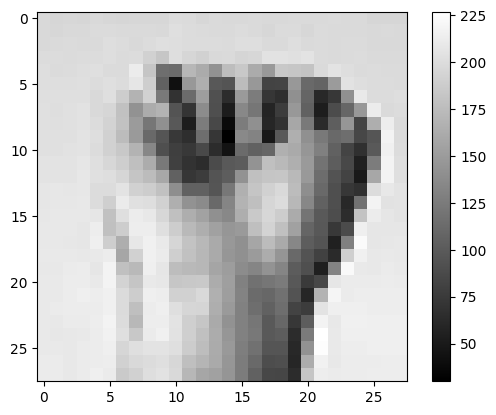

In [30]:
i = 0
fig = plt.figure()

tmp = np.reshape(X_train[i,:], (28,28))
plt.imshow(tmp, cmap = 'gray')
plt.colorbar()

In [31]:
scalerX = preprocessing.MinMaxScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [32]:
class_names = list(string.ascii_lowercase[:26].replace('j', '').replace('z', ''))
print("class: ", class_names)

class:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [33]:
num_images = np.sum(Y_train, axis=0)
print(num_images)

43650.0


In [38]:
print(Y_train)

[ 0.  0.  0. ... 24. 24. 24.]


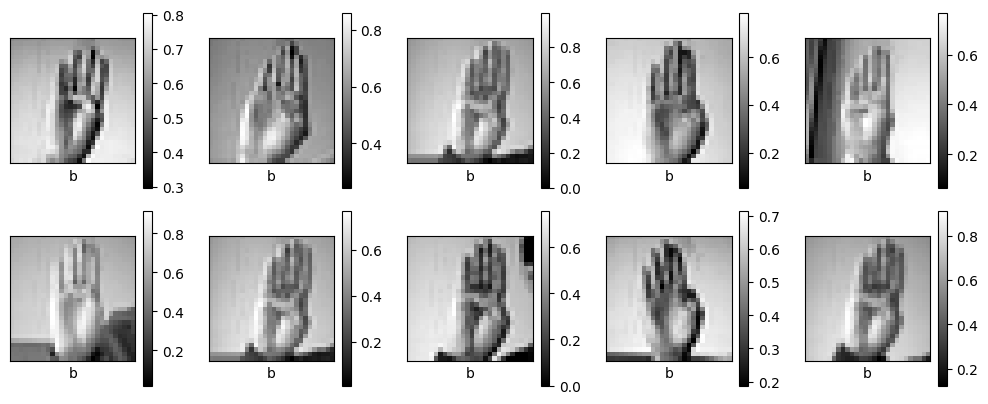

In [41]:
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  tmp = np.reshape(X_train[i+150,:], (28,28))
  plt.imshow(tmp, cmap = 'gray')
  plt.colorbar()
  # plt.imshow(X_train[i].squeeze(), cmap=plt.cm.binary)
  plt.xlabel(class_names[int((Y_train)[i+150])])
plt.tight_layout()
plt.show()

In [44]:
from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

grid = {'C': np.logspace(-4,3,5), # start point (10^), end point (10^), number of points, scala logaritimica
        'kernel': ['linear']}     # test anche con gaussiano, timing consuming

MS = GridSearchCV(estimator = SVC(), #
                  param_grid = grid,
                  scoring = 'accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 1)

H = MS.fit(X_train,Y_train)

M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0 33  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  4 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 32  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  6 16  0  0  0  0  0  0  9  0  0  5  0  1  0  0]
 [ 0  0  3  0  0  0  0  0  0  0 23  0  0  0  2  0  0  0  0  0  0  0 10  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 25  6  0  0  0  0  5  0  0  0  0  0  0]
 [ 2  0  1  2  0  3  0  0  2  0  0  1 23  3  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  5  0  1  0  2  0

<Figure size 640x480 with 0 Axes>

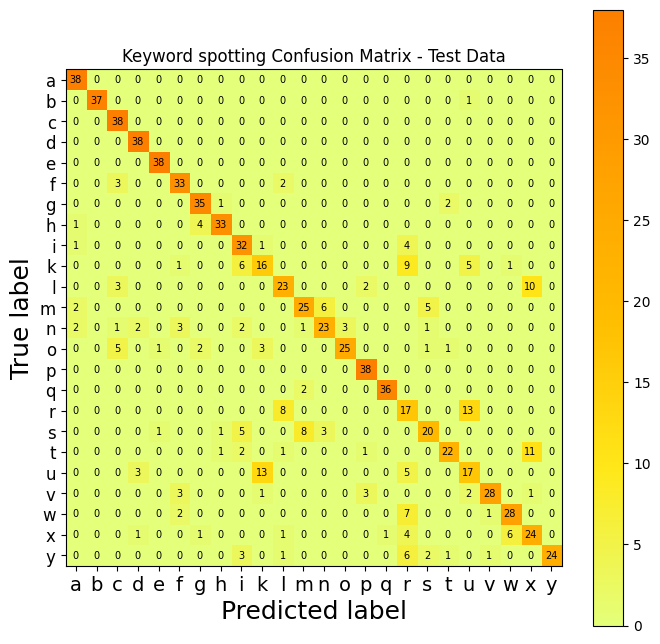

In [57]:
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Keyword spotting Confusion Matrix - Test Data')

plt.ylabel('True label', fontsize=18)

plt.xlabel('Predicted label', fontsize=18)

tick_marks = np.arange(len(classNames))

plt.xticks(tick_marks, classNames, fontsize=14)

plt.yticks(tick_marks, classNames, fontsize=12)

plt.colorbar()#io

#s = [['Y','N','N','N','N'], ['N','Y','N','N','N'],['N','N','Y','N','N'],['N','N','N','Y','N'],['N','N','N','N','Y']]

for i in range(24):

    for j in range(24):

        #plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente

plt.show()

In [58]:
from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

grid = {'C': np.logspace(-4,3,5), # start point (10^), end point (10^), number of points, scala logaritimica
        'kernel': ['linear']}     # test anche con gaussiano, timing consuming

MS = GridSearchCV(estimator = SVC(), #
                  param_grid = grid,
                  scoring = 'balanced_accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 0)

H = MS.fit(X_train,Y_train)

M = SVC(C = H.best_params_['C'],
        kernel = H.best_params_['kernel'])

M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



[[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0 33  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  4 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 32  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  6 16  0  0  0  0  0  0  9  0  0  5  0  1  0  0]
 [ 0  0  3  0  0  0  0  0  0  0 23  0  0  0  2  0  0  0  0  0  0  0 10  0]
 [ 2  0  0  0  0  0  0  0  0  0  0 25  6  0  0  0  0  5  0  0  0  0  0  0]
 [ 2  0  1  2  0  3  0  0  2  0  0  1 23  3  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  5  0  1  0  2  0

<Figure size 640x480 with 0 Axes>

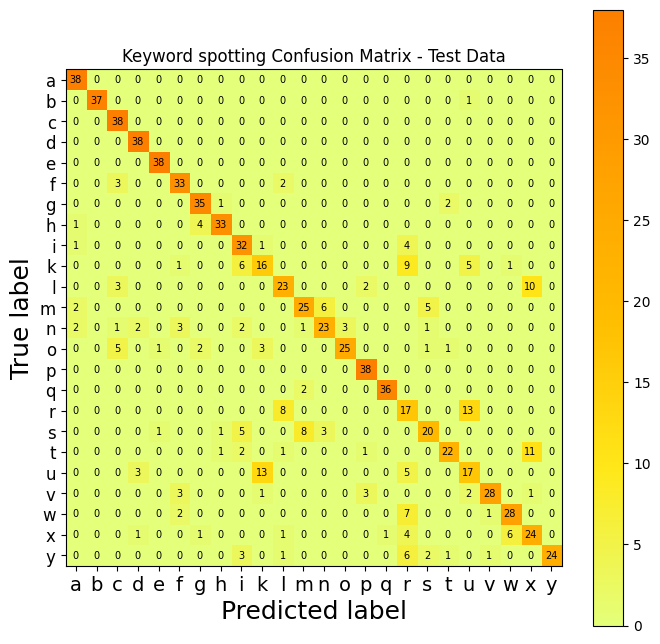

In [59]:
plt.clf()

plt.figure(figsize = (8,8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Wistia)

classNames = class_names

plt.title('Keyword spotting Confusion Matrix - Test Data')

plt.ylabel('True label', fontsize=18)

plt.xlabel('Predicted label', fontsize=18)

tick_marks = np.arange(len(classNames))

plt.xticks(tick_marks, classNames, fontsize=14)

plt.yticks(tick_marks, classNames, fontsize=12)

plt.colorbar()#io

#s = [['Y','N','N','N','N'], ['N','Y','N','N','N'],['N','N','Y','N','N'],['N','N','N','Y','N'],['N','N','N','N','Y']]

for i in range(24):

    for j in range(24):

        #plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

        plt.text(j,i,str(conf_matrix[i][j]), fontsize=7, horizontalalignment='center', verticalalignment='center') #così plotto in modo decente

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV # algoritmo per la ricerca degli hyperparameters ottimi nella grid
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

grid = {'penalty': ['l1', 'l2'],
        'loss': ['hinge', 'squared_hinge'],
        'C': np.logspace(-4,3,5)} # start point (10^), end point (10^), number of points, scala logaritimica

MS = GridSearchCV(estimator = LinearSVC(), #
                  param_grid = grid,
                  scoring = 'accuracy', # in questo modo otteniamo una media normale perchè abbiamo un numero uguale di samples per ogni classe,
                  # alrimenti si può usare balanced_accuracy nel caso in cui si ha un numero diverso di samples per classi e quindi una media pesata
                  cv = 10, # percentuale di samples ricavati e usati per il validation (dal learning dataset)
                  verbose = 1)

H = MS.fit(X_train,Y_train)

M = SVC(penalty = H.best_params_['penalty'],
        loss = H.best_params_['loss'],
        C = H.best_params_['C'])

print(SVC.penalty, SVC.loss, SVC.C)

M.fit(X_train,Y_train)

YP = M.predict(X_test)

conf_matrix = confusion_matrix(Y_test,YP)

print(conf_matrix)



Fitting 10 folds for each of 20 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w